In [2]:
#Imports
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import copy
from keras import backend as K
#from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.layers import Dense, Reshape, Conv1D, LeakyReLU, Flatten

from utils.modelgenerator import *
from utils.modelhandler import *
from utils.datahandler import *
from keras.callbacks import History
import matplotlib.pyplot as plt
import csv

/Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack_git/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.getcwd()))
df = pd.read_csv(cwd+'/data/2feature_engineering_data/df_with_final_features.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)

# Splits the DataFrame into smaller DataFrames for each user and selects specific columns of interest.
num_users = 6
df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

df_array[5]

,User6,temp,rhum,wspd,PC1,hour sin,hour cos,User6_lag_24hrs
Date,,,,,,,,
2012-07-08 00:00:00,0.509,9.8,85.0,0.0,-2.453691,0.000000,1.000000,0.836
2012-07-08 01:00:00,0.489,9.8,85.0,0.0,-2.453691,0.258819,0.965926,0.652
2012-07-08 02:00:00,0.573,9.8,85.0,0.0,-2.453691,0.500000,0.866025,0.673
2012-07-08 03:00:00,0.363,6.6,98.0,0.0,-2.946230,0.707107,0.707107,0.696
2012-07-08 04:00:00,0.595,6.6,98.0,0.0,-2.946230,0.866025,0.500000,0.695
...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,1.018,11.8,88.0,3.6,-1.044137,-0.965926,0.258819,1.291
2013-06-30 20:00:00,0.910,11.8,88.0,3.6,-1.044137,-0.866025,0.500000,0.883
2013-06-30 21:00:00,1.011,8.8,99.0,1.8,-2.332378,-0.707107,0.707107,1.499


In [4]:
#Train, Validation and Test datasets
sequence_length = 25
batch_size = 16
num_features = df_array[0].shape[1]

dh = Datahandler()

# Initialize Data Split Dictionaries: Sets up dictionaries to store train, validation, and test data for each user.
X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing 
    # Min-Max Scaling: Scales the data within each set (train, validation, test) to a specific range (typically between 0 and 1) to ensure uniformity and improve model convergence.
    train_df = dh.min_max_scaling(train_df)
    val_df = dh.min_max_scaling(val_df)
    test_df = dh.min_max_scaling(test_df)

    # Sequencing
    # Sequence Creation: Converts the data into sequences of a fixed length to feed into the model. This step is crucial for sequence prediction tasks, like time series forecasting.
    train_sequences = dh.create_sequences(train_df, sequence_length)
    val_sequences = dh.create_sequences(val_df, sequence_length)
    test_sequences = dh.create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = dh.prepare_data(train_sequences, batch_size)
    X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = dh.prepare_data(val_sequences, batch_size)
    X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = dh.prepare_data(test_sequences, batch_size)


In [5]:
#General Hyperparameters
# #All models
horizon = 1
max_epochs = 100
m1 = ModelGenerator()
mh = Modelhandler()

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()
#tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


#model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks=[early_stopping, timing_callback, custom_callback] #model_checkpoint

In [6]:
def fed_avg_weights(weight_list, clip_threshold=None):
    avg_grad = list()

    for grad_list_tuple in zip(*weight_list):
        layer_mean = tf.math.reduce_mean(grad_list_tuple, axis=0)

        if clip_threshold is not None:
            layer_mean = tf.clip_by_value(layer_mean, -clip_threshold, clip_threshold)

        avg_grad.append(layer_mean)

    return avg_grad

In [7]:
num_clusters = 2
y = np.loadtxt(f'../evaluations/clusters_KMeansNew{num_clusters}_dtw.csv', delimiter=',').astype(int)

cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([2, 3, 4, 5]), 1: array([1, 6])}

In [8]:
architecture = "BiLSTM_L1_U8"

lstm_layers = 1
lstm_units = 8
federated_rounds = 3

In [42]:
# Create global models for each cluser (2)
for cluster in range(num_clusters):
#Build and save global model
    global_model = m1.build_bilstm_model(X_train[f'user{1}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
    global_model.save(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster}/{architecture}/FederatedRound{0}")

INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound0/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound0/assets


In [43]:
federated_rounds = 3
for federated_round  in range(federated_rounds):
    print("Started Federated training round ----------", federated_round+1, f"/ {federated_rounds}")

    for cluster_number, users_in_cluster in cluster_users.items():
        print(f"Cluster {cluster_number}:")

        #Get global models weights
        global_model = keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
        global_model_weights = global_model.get_weights()

        #initial list for local model weights
        local_model_weight_list = list()


        #for idx, user in enumerate(df_array): 
        for user_index in users_in_cluster:
            user_df = df_array[user_index-1]  # Get the user's DataFrame from the array
            print(f"User {user_index}") 
                      
            #build and compile local model X_train, batch_size, horizon, dense_units,  expert_units, num_experts, m1
            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

            #set local model weight to the weight of the global model
            local_model.set_weights(global_model_weights)
            
            #Fit local model to local data
            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model, 
                loss=loss, 
                metrics=metrics, 
                X_train=X_train[f'user{user_index}'],
                y_train = y_train[f'user{user_index}'], 
                max_epochs = max_epochs, 
                batch_size=batch_size, 
                X_val=X_val[f'user{user_index}'], 
                y_val=y_val[f'user{user_index}'], 
                X_test=X_test[f'user{user_index}'], 
                y_test=y_test[f'user{user_index}'], 
                callbacks=callbacks, 
                user=f'user{user_index}', 
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
            )
            #add model weights to list        
            local_model_weights = local_model.get_weights()
            local_model_weight_list.append(local_model_weights)
        
            #clear session to free memory after each communication round
            K.clear_session()
        
        #to get the average over all the local model, we simply take the sum of the scaled weights

        average_weights = fed_avg_weights(local_model_weight_list)
        #update global model 
        global_model.set_weights(average_weights)
        #Save global models
        global_model.save(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round+1}")
        print("Saved Global models")


Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound1/assets


Saved Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound2/assets


Saved Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_0/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/global_BiLSTM_model/cluster_1/BiLSTM_L1_U8/FederatedRound3/assets


Saved Global models


In [44]:
#Evaluation
all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

for cluster_number, users_in_cluster in cluster_users.items():
    print(f"Cluster {cluster_number}:")

    #Get global models weights
    global_model = tf.keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}", compile=False)

    #for idx, user in enumerate(df_array): 
    for user_index in users_in_cluster:
        print("User: ", user_index)
        for round in range(3):
            global_model = tf.keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}", compile=False)
            local_model = m1.build_bilstm_model(X_train[f'user{user_index}'], horizon, num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
            local_model.set_weights(global_model.get_weights())
            
            history, user_results = mh.compile_fit_evaluate_model(
                model=local_model, 
                loss=loss, 
                metrics=metrics, 
                X_train=X_train[f'user{user_index}'],
                y_train = y_train[f'user{user_index}'], 
                max_epochs = 1, 
                batch_size=batch_size, 
                X_val=X_val[f'user{user_index}'], 
                y_val=y_val[f'user{user_index}'], 
                X_test=X_test[f'user{user_index}'], 
                y_test=y_test[f'user{user_index}'], 
                callbacks=callbacks, 
                user=f'user{user_index}', 
                hyper=architecture,
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
            )
        
            # Add the 'architecture' column from dense_user_results to dense_results
            all_results = pd.merge(all_results, user_results, how='outer')  

results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])
for idx in range(len(df_array)):

    new_row = {
        'architecture': architecture,
        'train_time': all_results[all_results["user"]==f"user{idx+1}"]["train_time"].mean(), 
        'avg_time_epoch' : all_results[all_results["user"]==f"user{idx+1}"]["avg_time_epoch"].mean(),
        'mse': all_results[all_results["user"]==f"user{idx+1}"]["mse"].mean(),
        'mse_std' : all_results[all_results["user"]==f"user{idx+1}"]["mse"].std(),
        'rmse': all_results[all_results["user"]==f"user{idx+1}"]["rmse"].mean(),
        'rmse_std' : all_results[all_results["user"]==f"user{idx+1}"]["rmse"].std(),
        'mape': all_results[all_results["user"]==f"user{idx+1}"]["mape"].mean(),
        'mape_std' : all_results[all_results["user"]==f"user{idx+1}"]["mape"].std(),
        'mae': all_results[all_results["user"]==f"user{idx+1}"]["mae"].mean(),
        'mae_std' : all_results[all_results["user"]==f"user{idx+1}"]["mae"].std(),
    }
    results.loc[len(results)] = new_row

# Get the parent directory of the current working directory
parent_folder = os.path.dirname(os.getcwd())
folder_name = 'results_without_noise'
file_name = f'results_{max_epochs}_epochs_6_users.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Save Results to CSV File (overwriting previous results)
results.to_csv(file_path, index=False)

# Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
cluster_number = 1  # Change this to the cluster number you are interested in
users_in_cluster = cluster_users[cluster_number]

# Adjust the user indices to match the 0-based index
adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

# Filter the results DataFrame to include only the users in the specified cluster
cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

#Calculate the sum of the MSE values for the users in the specified cluster
mse_sum = cluster_results['mse'].sum()
print(f"Sum of 'mse' column for users in cluster {cluster_number}:", mse_sum)

results

Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Sum of 'mse' column for users in cluster 1: 0.05485901298622291


,architecture,train_time,avg_time_epoch,mse,mse_std,rmse,rmse_std,mape,mape_std,mae,mae_std
0,BiLSTM_L1_U8,2.669166,2.592543,0.033976,0.000592,0.184322,0.001603,88356.187500,7501.934043,0.122932,0.001588
1,BiLSTM_L1_U8,3.275978,3.186780,0.017740,0.000126,0.133193,0.000474,302704.593750,15406.893768,0.078635,0.000625
2,BiLSTM_L1_U8,2.670529,2.596703,0.019167,0.000102,0.138443,0.000369,68633.395833,8410.159830,0.076909,0.004046
3,BiLSTM_L1_U8,2.789397,2.712946,0.021594,0.000234,0.146949,0.000798,157683.484375,2254.540913,0.062185,0.001657
4,BiLSTM_L1_U8,2.745823,2.671428,0.014086,0.000068,0.118684,0.000286,72594.500000,741.537061,0.076794,0.001076
5,BiLSTM_L1_U8,2.737387,2.661393,0.020883,0.000303,0.144506,0.001049,105784.630208,9533.583868,0.105864,0.001303


52/52 [==============================] - 0s 1ms/step


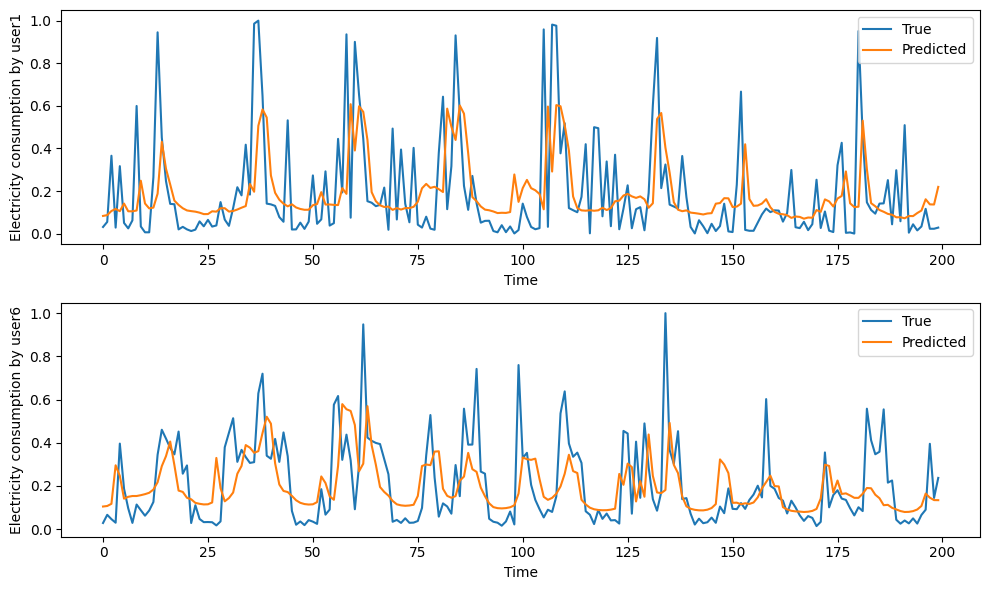

In [25]:
federated_round = 3

global_model = keras.models.load_model(cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
global_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006), metrics=metrics)

# List of users for whom you want to plot predictions
users = ['user1', 'user6']

# Define the number of rows and columns for subplots
num_rows = len(users)
num_cols = 1  # Since you want each plot to be in a separate row

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))

# Iterate over users and plot predictions
for i, user in enumerate(users):
    pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)

    start = 600
    stop = start + 200
    ax = axes[i] if num_rows > 1 else axes  # Use the appropriate axis for plotting

    ax.plot(y_test[user][start:stop], label='True')
    ax.plot(pred_global_model[start:stop], label='Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Electricity consumption by {user}')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

52/52 [==============================] - 0s 1ms/step


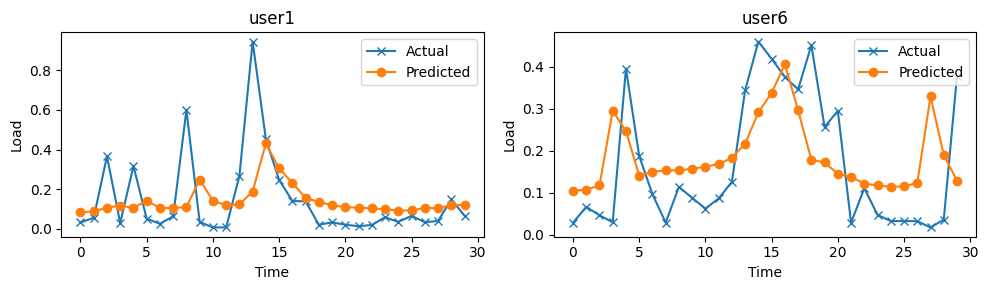

In [34]:
# List of users for whom you want to plot predictions
users = ['user1', 'user6']

# Define the number of rows and columns for subplots
num_rows = 1
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3))
axes = axes.flatten()

# Iterate over users and plot predictions
for i, user in enumerate(users):
    pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)

    start = 600
    stop = start + 30
    
    ax = axes[i] if num_rows * num_cols > 1 else axes  # Use the appropriate axis for plotting

    # Plot actual values
    ax.plot(y_test[user][start:stop], label='Actual', marker='x')
    # Plot predicted values
    ax.plot(pred_global_model[start:stop], label='Predicted', marker='o')
    ax.set_title(f"{user}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Load')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Data Poisoning Attack with Uniform distribution

In [15]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 5, 7, 10, 12]  # Define your desired noise scales

def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.uniform(0, noise_scale, original_data.shape)
    return adversarial_data

for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user6
    user6_adversarial_data = generate_adversarial_data(X_train['user6'], noise_scale)

    # Inject adversarial data into the training dataset for user6
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user6'] = (user6_adversarial_data * X_train['user6']) + user6_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            print(f"Cluster {cluster_number}:")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local model, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")

Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Testing noise scale: 5
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_5/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_5/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_5/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_5/assets


Saved Poisoned Global models
Testing noise scale: 7
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_7/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_7/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_7/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_7/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_7/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_7/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_7/assets


Saved Poisoned Global models
Testing noise scale: 10
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_10/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_10/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_10/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_10/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_10/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_10/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_10/assets


Saved Poisoned Global models
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Cluster 0:
User 2
User 3
User 4
User 5


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_0/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models
Cluster 1:
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models


In [16]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 5, 7, 10, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        print(f"Cluster {cluster_number}:")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user6_3.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 1  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user6_3.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 0.3
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 0.5
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 0.8
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 1
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 5
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 7
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 10
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
Evalution noise scale: 12
Cluster 0:
User:  2
User:  3
User:  4
User:  5
Cluster 1:
User:  1
User:  6
MSE sums for each user in cluster: {'user1': {0.2: 0.03351018205285072, 0.3: 0.03

52/52 [==============================] - 0s 990us/step


52/52 [==============================] - 0s 975us/step


52/52 [==============================] - 0s 970us/step


52/52 [==============================] - 0s 1ms/step


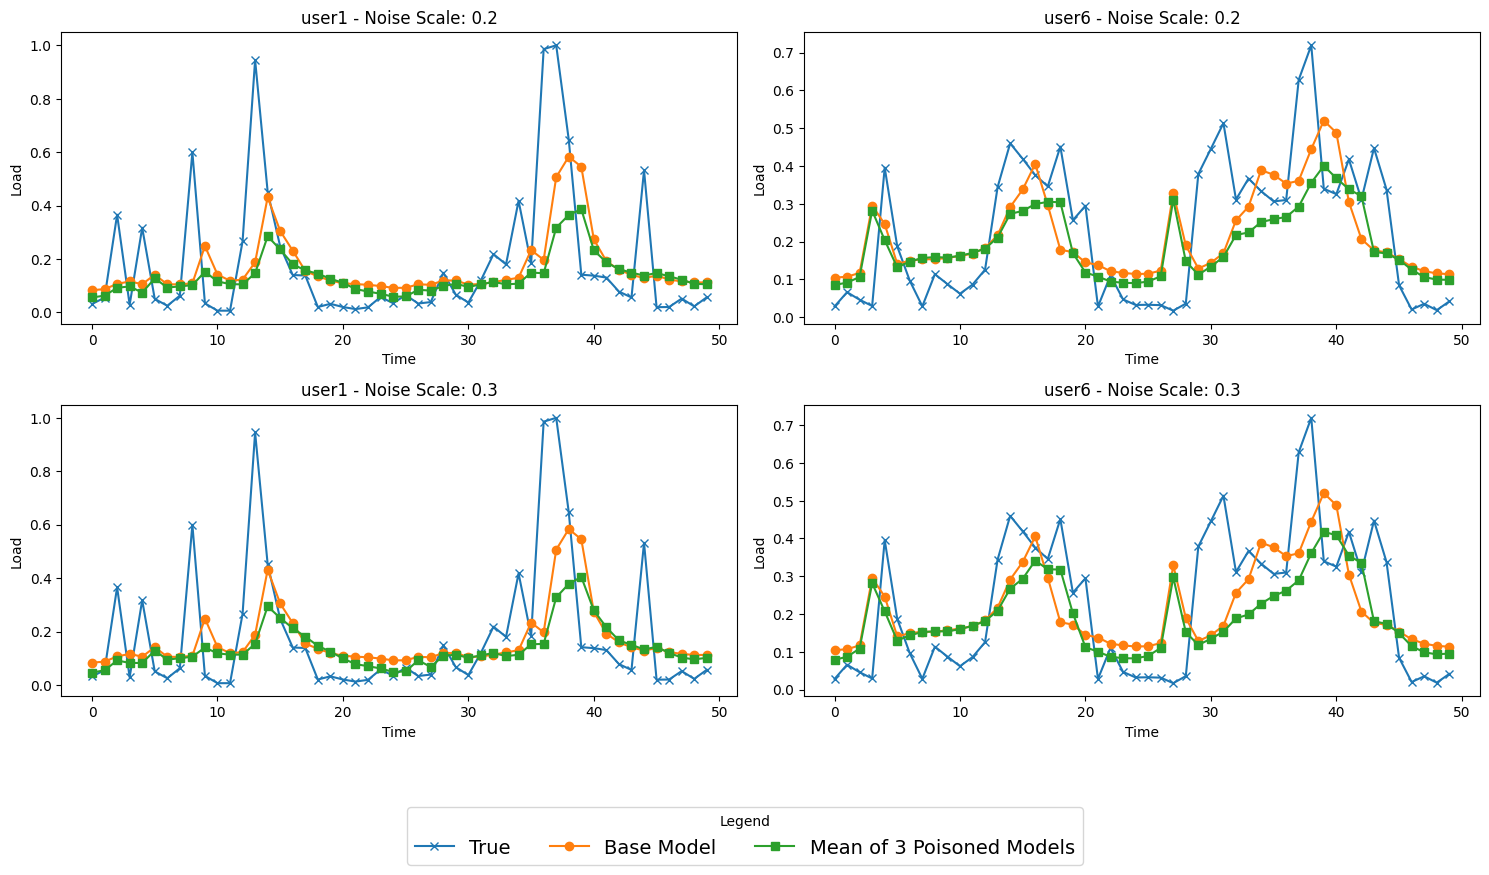

In [17]:
# Define the list of users and models to compare
users = ['user1', 'user6']
models = ['global', 'poisoned']  # Updated for simplicity
noise_scales = [0.2, 0.3]  # Define your desired noise scales

# Define the number of rows and columns for subplots
num_rows = len(noise_scales)  # Number of rows based on noise scales
num_cols = len(users)  # Number of columns based on users
# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows + 2))
axes = axes.flatten()

# Iterate over noise scales and users to plot predictions
for i, noise_scale in enumerate(noise_scales):
    for j, user in enumerate(users):
        # Load the global model
        global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}",
            compile=False
        )
        global_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        # Load poisoned models for the current noise scale
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        poisoned_global_model_2 = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_2/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model_2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        poisoned_global_model_3 = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model_3.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        # Get predictions from all models
        pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model = poisoned_global_model.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model_2 = poisoned_global_model_2.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model_3 = poisoned_global_model_3.predict(X_test[user], batch_size=batch_size)

        # Calculate the mean of the poisoned model predictions
        mean_pred_poisoned = np.mean([pred_poisoned_global_model, pred_poisoned_global_model_2, pred_poisoned_global_model_3], axis=0)

        start = 600
        stop = start + 50
        ax = axes[i * len(users) + j]  # Determine the correct axis

        # Plot true values
        ax.plot(y_test[user][start:stop], label='True', marker='x')
        # Plot base global model predictions
        ax.plot(pred_global_model[start:stop], label='Base Model', marker='o')
        # Plot mean of poisoned global model predictions
        ax.plot(mean_pred_poisoned[start:stop], label=f'Mean of 3 Poisoned Models', marker='s')
        
        ax.set_title(f"{user} - Noise Scale: {noise_scale}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Load')

# Create a single legend for all plots and place it at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='Legend',  prop={'size': 14})

# Adjust layout to make space for the legend at the bottom of the plots
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the top to make space for the plots
plt.show()


52/52 [==============================] - 0s 1ms/step


52/52 [==============================] - 0s 1ms/step


52/52 [==============================] - 0s 973us/step


52/52 [==============================] - 0s 1ms/step


52/52 [==============================] - 0s 971us/step


52/52 [==============================] - 0s 974us/step


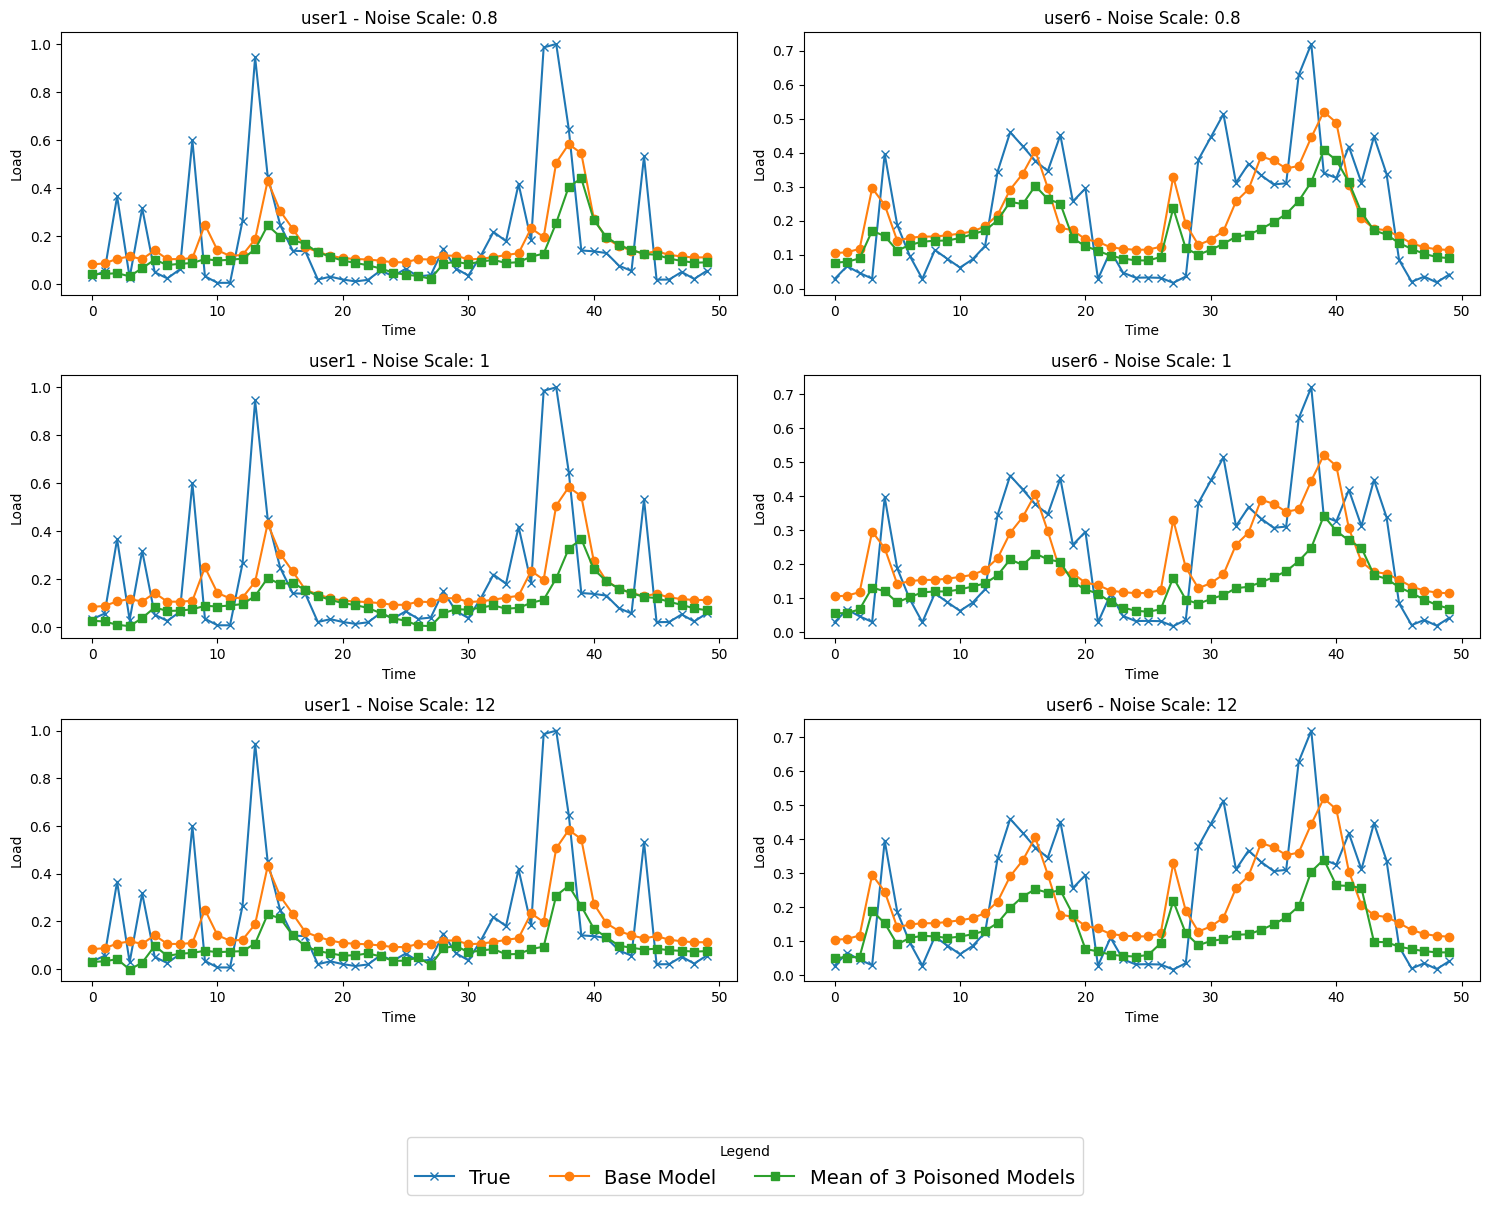

In [16]:
# Define the list of users and models to compare
users = ['user1', 'user6']
models = ['global', 'poisoned']  # Updated for simplicity
noise_scales = [0.8, 1, 12]  # Define your desired noise scales

# Define the number of rows and columns for subplots
num_rows = len(noise_scales)  # Number of rows based on noise scales
num_cols = len(users)  # Number of columns based on users
# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows + 2))
axes = axes.flatten()

# Iterate over noise scales and users to plot predictions
for i, noise_scale in enumerate(noise_scales):
    for j, user in enumerate(users):
        # Load the global model
        global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/global_BiLSTM_model/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}",
            compile=False
        )
        global_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        # Load poisoned models for the current noise scale
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        poisoned_global_model_2 = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_2/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model_2.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        poisoned_global_model_3 = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_3/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}",
            compile=False
        )
        poisoned_global_model_3.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

        # Get predictions from all models
        pred_global_model = global_model.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model = poisoned_global_model.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model_2 = poisoned_global_model_2.predict(X_test[user], batch_size=batch_size)
        pred_poisoned_global_model_3 = poisoned_global_model_3.predict(X_test[user], batch_size=batch_size)

        # Calculate the mean of the poisoned model predictions
        mean_pred_poisoned = np.mean([pred_poisoned_global_model, pred_poisoned_global_model_2, pred_poisoned_global_model_3], axis=0)

        start = 600
        stop = start + 50
        ax = axes[i * len(users) + j]  # Determine the correct axis

        # Plot true values
        ax.plot(y_test[user][start:stop], label='True', marker='x')
        # Plot base global model predictions
        ax.plot(pred_global_model[start:stop], label='Base Model', marker='o')
        # Plot mean of poisoned global model predictions
        ax.plot(mean_pred_poisoned[start:stop], label=f'Mean of 3 Poisoned Models', marker='s')
        
        ax.set_title(f"{user} - Noise Scale: {noise_scale}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Load')

# Create a single legend for all plots and place it at the bottom
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='Legend', prop={'size': 14})


# Adjust layout to make space for the legend at the bottom of the plots
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the top to make space for the plots
plt.show()


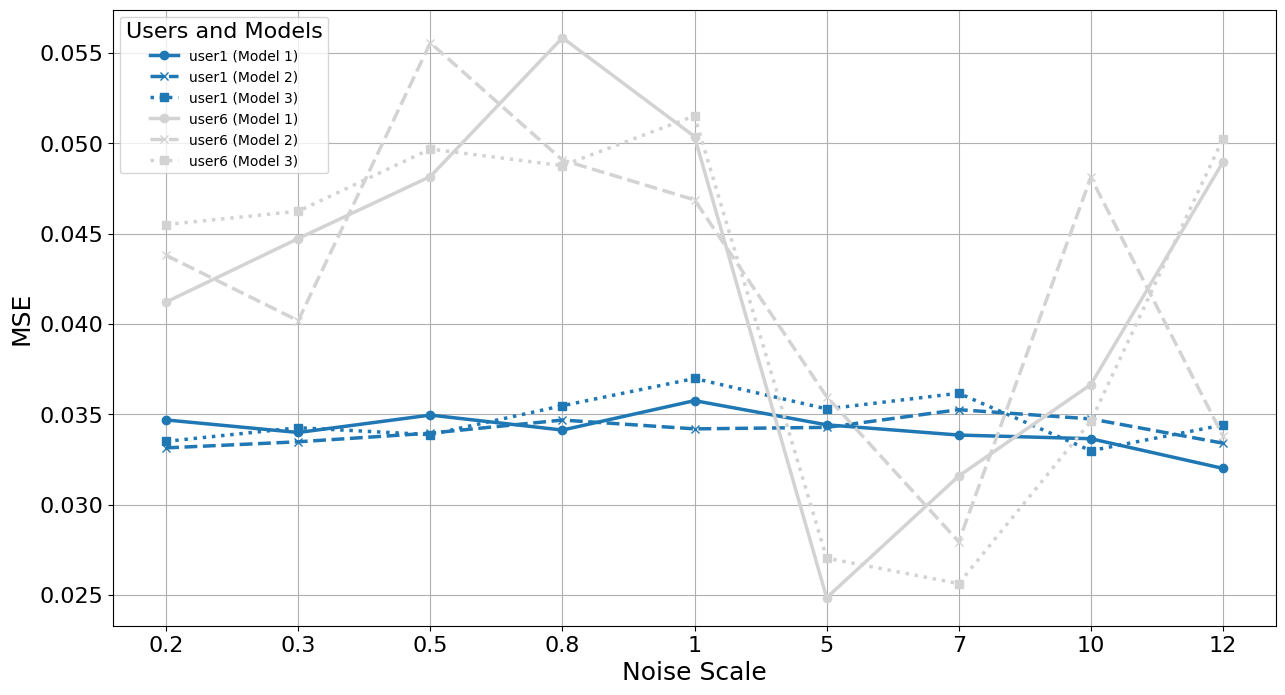

In [48]:
df_base = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6.csv')
df_additional_2 = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6_2.csv')
df_additional_3 = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6_3.csv')

# Get the list of users and noise scales from the columns
users = df_base['User'].values
#noise_scales = df_base.columns[1:]
noise_scales = ['0.2', '0.3', '0.5', '0.8', '1', '5', '7', '10','12' ]

# Define colors for each user
user_colors = {
    'user1': '#1f77b4',
    'user6': 'lightgray'
}

# Define line styles for each model
line_styles = {
    'Model 1': 'solid',
    'Model 2': 'dashed',
    'Model 3': 'dotted'
}

# Initialize dictionaries to store MSE values for each user across noise scales
mse_per_user = {user: [] for user in users}
mse_per_user_additional_2 = {user: [] for user in users}
mse_per_user_additional_3 = {user: [] for user in users}

# Populate the dictionaries with MSE values for each noise scale
for user in users:
    mse_per_user[user] = df_base[df_base['User'] == user].values[0][1:].tolist()
    mse_per_user_additional_2[user] = df_additional_2[df_additional_2['User'] == user].values[0][1:].tolist()
    mse_per_user_additional_3[user] = df_additional_3[df_additional_3['User'] == user].values[0][1:].tolist()

plt.figure(figsize=(15, 8))

# Plot lines for each user and each model

for user in users:
    plt.plot(noise_scales, mse_per_user[user], label=f'{user} (Model 1)', color=user_colors[user], linestyle=line_styles['Model 1'], marker='o',linewidth=2.5)
    plt.plot(noise_scales, mse_per_user_additional_2[user], label=f'{user} (Model 2)', color=user_colors[user], linestyle=line_styles['Model 2'], marker='x', linewidth=2.5)
    plt.plot(noise_scales, mse_per_user_additional_3[user], label=f'{user} (Model 3)', color=user_colors[user], linestyle=line_styles['Model 3'], marker='s',linewidth=2.5)

# Increase the font size for x and y axis ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Effect of Noise Scale on MSE for Different Users and Models')
plt.xlabel('Noise Scale', fontsize=18)
plt.ylabel('MSE', fontsize=18)

plt.grid(True)
plt.legend(title='Users and Models', fontsize=10, title_fontsize=16)
plt.show()


### Data Poisoning attack using Normal distribution

In [9]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales

def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.normal(0, noise_scale, original_data.shape)
    return adversarial_data

for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user6
    user6_adversarial_data = generate_adversarial_data(X_train['user6'], noise_scale)

    # Inject adversarial data into the training dataset for user6
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user6'] = (user6_adversarial_data * X_train['user6']) + user6_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            if 6 not in users_in_cluster:
                print(f"Skipping Cluster {cluster_number} as it does not contain user6")
                continue

            print(f"Cluster {cluster_number} contains user6")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local model, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")

Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models


In [10]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        if 6 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user6")
            continue

        print(f"Cluster {cluster_number} contains user6")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_normal/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user6_normal.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 1  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user6_normal.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.5
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.8
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 1
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 12
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
MSE sums for each user in cluster: {'user1': {0.2: 0.03177145371834437, 0.3: 0.03428989772995313, 0.5: 0.03425074741244316, 0.8: 0.03493668884038925, 1: 0.03455898786584536, 12: 0.03252128014961878}, 'user6': {0.2: 0.04133529091874758, 0.3: 0.033000281701485314, 0.5: 0.02992044948041439, 0.8: 0

### Data Poisoning Attack using Laplace Disribution

In [17]:
# Define your desired noise scales
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]

# Function to generate adversarial data using exponential distribution
def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.laplace(0, noise_scale, original_data.shape)
    return adversarial_data

# Loop over different noise scales
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user6
    user6_adversarial_data = generate_adversarial_data(X_train['user6'], noise_scale)

    # Inject adversarial data into the training dataset for user6
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user6'] = X_train['user6'] + user6_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            if 6 not in users_in_cluster:
                print(f"Skipping Cluster {cluster_number} as it does not contain user6")
                continue

            print(f"Cluster {cluster_number} contains user6")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local models, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")


Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models


In [18]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        if 6 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user6")
            continue

        print(f"Cluster {cluster_number} contains user6")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_laplace/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user6_laplace.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 1  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user6_laplace.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.5
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.8
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 1
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 12
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
MSE sums for each user in cluster: {'user1': {0.2: 0.035705313086509705, 0.3: 0.036529991775751114, 0.5: 0.03739390273888906, 0.8: 0.036037627607584, 1: 0.03330873946348826, 12: 0.03290340676903725}, 'user6': {0.2: 0.027267033234238625, 0.3: 0.028560128062963486, 0.5: 0.024900824452439945, 0.8:

### Data Poisoning Attack using Exponential Distribution

In [34]:
# Define your desired noise scales
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]

# Function to generate adversarial data using exponential distribution
def generate_adversarial_data(original_data, noise_scale):
    adversarial_data = np.random.exponential(noise_scale, original_data.shape)
    return adversarial_data

# Loop over different noise scales
for noise_scale in noise_scales:
    print(f"Testing noise scale: {noise_scale}")
    
    # Generate adversarial data for user6
    user6_adversarial_data = generate_adversarial_data(X_train['user6'], noise_scale)

    # Inject adversarial data into the training dataset for user6
    X_train_poisoned = copy.deepcopy(X_train)
    X_train_poisoned['user6'] = X_train['user6'] + user6_adversarial_data

    federated_rounds = 3
    for federated_round in range(federated_rounds):
        print("Started Federated training round ----------", federated_round + 1, f"/ {federated_rounds}")

        for cluster_number, users_in_cluster in cluster_users.items():
            if 6 not in users_in_cluster:
                print(f"Skipping Cluster {cluster_number} as it does not contain user6")
                continue

            print(f"Cluster {cluster_number} contains user6")

            # Get global models weights
            poisoned_global_model = keras.models.load_model(
                cwd + f"/models/FL/BiLSTM/global_BiLSTM_model_6_users/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round}", compile=False)
            poisoned_global_model_weights = poisoned_global_model.get_weights()

            # Initial list for local model weights
            poisoned_local_model_weight_list = list()

            for user_index in users_in_cluster:
                user_df = df_array[user_index - 1]  # Get the user's DataFrame from the array
                print(f"User {user_index}")

                # Build and compile local model
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                              num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)

                # Set local model weight to the weight of the global model
                poisoned_local_model.set_weights(poisoned_global_model_weights)

                # Fit local model to local data
                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=max_epochs,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                )

                # Add model weights to list
                poisoned_local_model_weights = poisoned_local_model.get_weights()
                poisoned_local_model_weight_list.append(poisoned_local_model_weights)

                # Clear session to free memory after each communication round
                K.clear_session()

            # To get the average over all the local models, we simply take the sum of the scaled weights
            average_weights = fed_avg_weights(poisoned_local_model_weight_list)
            # Update poisoned global model
            poisoned_global_model.set_weights(average_weights)
            # Save poisoned global models
            poisoned_global_model.save(cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_{cluster_number}/{architecture}/FederatedRound{federated_round + 1}/NoiseScale_{noise_scale}")
            print("Saved Poisoned Global models")


Testing noise scale: 0.2
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.2/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.2/assets


Saved Poisoned Global models
Testing noise scale: 0.3
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.3/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.3/assets


Saved Poisoned Global models
Testing noise scale: 0.5
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.5/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.5/assets


Saved Poisoned Global models
Testing noise scale: 0.8
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_0.8/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_0.8/assets


Saved Poisoned Global models
Testing noise scale: 1
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_1/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_1/assets


Saved Poisoned Global models
Testing noise scale: 12
Started Federated training round ---------- 1 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound1/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 2 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound2/NoiseScale_12/assets


Saved Poisoned Global models
Started Federated training round ---------- 3 / 3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User 1
User 6


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


INFO:tensorflow:Assets written to: /Users/krupalikumbhani/Documents/Koblenz/Summer Sem 2024/Master Thesis/Sec_FL_Attack/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_1/BiLSTM_L1_U8/FederatedRound3/NoiseScale_12/assets


Saved Poisoned Global models


In [35]:
noise_scales = [0.2, 0.3, 0.5, 0.8, 1, 12]  # Define your desired noise scales
# Initialize the dictionary to store MSE values for each user and noise scale
mse_results_per_user_separate = {}

# Evaluation
for noise_scale in noise_scales:
    print(f"Evalution noise scale: {noise_scale}")

    all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])

    for cluster_number, users_in_cluster in cluster_users.items():
        if 6 not in users_in_cluster:
            print(f"Skipping Cluster {cluster_number} as it does not contain user6")
            continue

        print(f"Cluster {cluster_number} contains user6")

        # Get global models weights
        poisoned_global_model = tf.keras.models.load_model(
            cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)

        for user_index in users_in_cluster:
            print("User: ", user_index)
            for round in range(3):
                poisoned_global_model = tf.keras.models.load_model(
                    cwd + f"/models/FL/BiLSTM/poisoned_global_BiLSTM_model_user6_exponential/cluster_{cluster_number}/{architecture}/FederatedRound{federated_rounds}/NoiseScale_{noise_scale}", compile=False)
                poisoned_local_model = m1.build_bilstm_model(X_train_poisoned[f'user{user_index}'], horizon,
                                                             num_layers=lstm_layers, units=lstm_units, batch_size=batch_size)
                poisoned_local_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006),
                                             metrics=metrics)
                poisoned_local_model.set_weights(poisoned_global_model.get_weights())

                history, user_results = mh.compile_fit_evaluate_model(
                    model=poisoned_local_model,
                    loss=loss,
                    metrics=metrics,
                    X_train=X_train_poisoned[f'user{user_index}'],
                    y_train=y_train[f'user{user_index}'],
                    max_epochs=1,
                    batch_size=batch_size,
                    X_val=X_val[f'user{user_index}'],
                    y_val=y_val[f'user{user_index}'],
                    X_test=X_test[f'user{user_index}'],
                    y_test=y_test[f'user{user_index}'],
                    callbacks=callbacks,
                    user=f'user{user_index}',
                    hyper=architecture,
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0006)
                )

                # Add the 'architecture' column from dense_user_results to dense_results
                all_results = pd.merge(all_results, user_results, how='outer')

    results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse', 'mse_std', 'rmse', 'rmse_std', 'mape', 'mape_std', 'mae', 'mae_std'])
    for idx in range(len(df_array)):
        new_row = {
            'architecture': architecture,
            'train_time': all_results[all_results["user"] == f"user{idx + 1}"]["train_time"].mean(),
            'avg_time_epoch': all_results[all_results["user"] == f"user{idx + 1}"]["avg_time_epoch"].mean(),
            'mse': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].mean(),
            'mse_std': all_results[all_results["user"] == f"user{idx + 1}"]["mse"].std(),
            'rmse': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].mean(),
            'rmse_std': all_results[all_results["user"] == f"user{idx + 1}"]["rmse"].std(),
            'mape': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].mean(),
            'mape_std': all_results[all_results["user"] == f"user{idx + 1}"]["mape"].std(),
            'mae': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].mean(),
            'mae_std': all_results[all_results["user"] == f"user{idx + 1}"]["mae"].std(),
        }
        results.loc[len(results)] = new_row

    # Get the parent directory of the current working directory
    parent_folder = os.path.dirname(os.getcwd())
    folder_name = 'results_with_noise'
    file_name = f'epochs_{max_epochs}_noise_scale_{noise_scale}_user6_exponential.csv'
    parent_path = os.path.join(parent_folder, folder_name)

    # Construct the path for the CSV file inside the parent folder
    file_path = os.path.join(parent_path, file_name)

    # Save Results to CSV File (overwriting previous results)
    results.to_csv(file_path, index=False)

    # Assuming cluster_users is a dictionary with cluster numbers as keys and lists of user indices as values
    cluster_number = 1  # Change this to the cluster number you are interested in
    users_in_cluster = cluster_users[cluster_number]

    # Adjust the user indices to match the 0-based index
    adjusted_users_in_cluster = [user_index - 1 for user_index in users_in_cluster]

    # Filter the results DataFrame to include only the users in the specified cluster
    cluster_results = results[results.index.isin(adjusted_users_in_cluster)]

    # Calculate the sum of the MSE values for each user separately and add to the dictionary
    for user_index in users_in_cluster:
        user_key = f"user{user_index}"
        if user_key not in mse_results_per_user_separate:
            mse_results_per_user_separate[user_key] = {}
        user_mse_sum = cluster_results[cluster_results.index == user_index - 1]['mse'].sum()
        mse_results_per_user_separate[user_key][noise_scale] = user_mse_sum

# Save the combined results to a CSV file
folder_name = 'seperate_user_results'
file_name = 'combined_mse_results_user6_exponential.csv'
parent_path = os.path.join(parent_folder, folder_name)

# Construct the path for the CSV file inside the parent folder
file_path = os.path.join(parent_path, file_name)

# Open the CSV file in write mode
with open(file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write header row
    header = ['User'] + [f'NoiseScale_{ns}' for ns in noise_scales]
    writer.writerow(header)
    
    # Write each dictionary item as a row
    for user, noise_scale_dict in mse_results_per_user_separate.items():
        row = [user] + [noise_scale_dict.get(ns, None) for ns in noise_scales]
        writer.writerow(row)

print("MSE sums for each user in cluster:", mse_results_per_user_separate)


Evalution noise scale: 0.2
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.3
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.5
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 0.8
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 1
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
Evalution noise scale: 12
Skipping Cluster 0 as it does not contain user6
Cluster 1 contains user6
User:  1
User:  6
MSE sums for each user in cluster: {'user1': {0.2: 0.03360787282387415, 0.3: 0.035029537975788116, 0.5: 0.036167080203692116, 0.8: 0.036219252894322075, 1: 0.03543009733160337, 12: 0.032433267682790756}, 'user6': {0.2: 0.04373130947351456, 0.3: 0.0408319483200709, 0.5: 0.03159866854548454, 0.8:

### Comparision graph for the different distributions

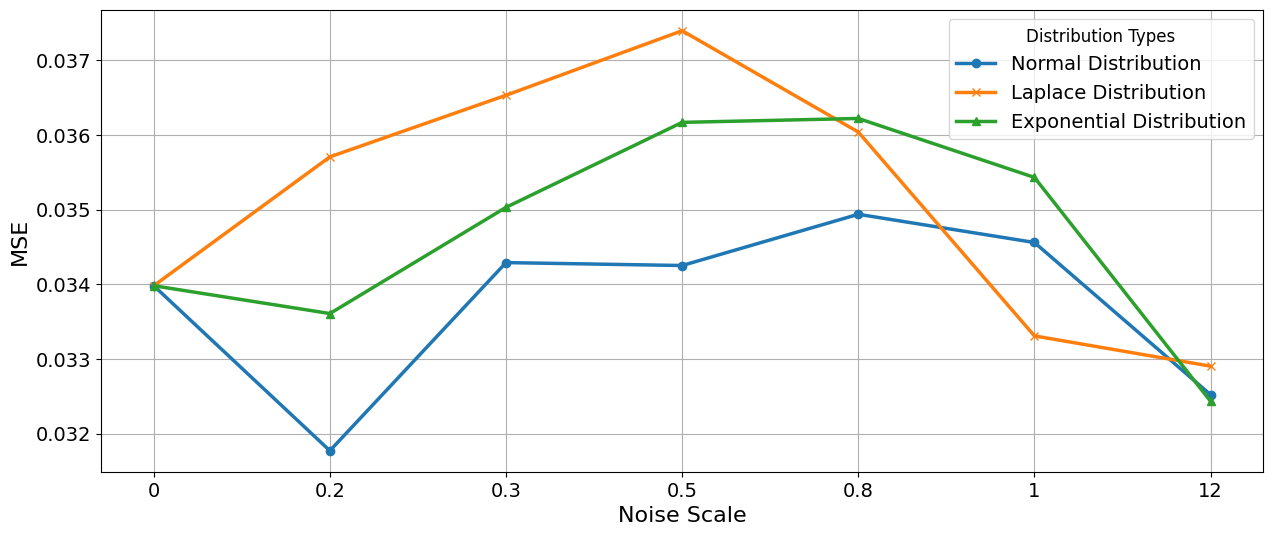

In [3]:
# Read the data
df_base = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6_normal.csv')
df_base_1 = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6_laplace.csv')
df_base_2 = pd.read_csv(cwd + '/seperate_user_results/combined_mse_results_user6_exponential.csv')

# Get the list of noise scales from the columns
noise_scales = ['0', '0.2', '0.3', '0.5', '0.8', '1', '12']

# Define colors for user1 and line styles
user_colors = {
    'Normal Distribution': '#1f77b4',
    'Laplace Distribution': '#ff7f0e',
    'Exponential Distribution': '#2ca02c'
}

line_styles = {
    'Normal Distribution': 'solid',
    'Laplace Distribution': 'solid',
    'Exponential Distribution': 'solid'
}

# Extract data for user1 and prepend the base value
base_value = 0.03398
user = 'user1'
mse_per_user = [base_value] + df_base[df_base['User'] == user].values[0][1:].tolist()
mse_per_user_additional_2 = [base_value] + df_base_1[df_base_1['User'] == user].values[0][1:].tolist()
mse_per_user_additional_3 = [base_value] + df_base_2[df_base_2['User'] == user].values[0][1:].tolist()

# Create the plot
plt.figure(figsize=(15, 6))

# Plot lines for user1 and each distribution
plt.plot(noise_scales, mse_per_user, 
         label='Normal Distribution', 
         color=user_colors['Normal Distribution'], 
         linestyle=line_styles['Normal Distribution'], 
         marker='o', linewidth=2.5)

plt.plot(noise_scales, mse_per_user_additional_2, 
         label='Laplace Distribution', 
         color=user_colors['Laplace Distribution'], 
         linestyle=line_styles['Laplace Distribution'], 
         marker='x', linewidth=2.5)

plt.plot(noise_scales, mse_per_user_additional_3, 
         label='Exponential Distribution', 
         color=user_colors['Exponential Distribution'], 
         linestyle=line_styles['Exponential Distribution'], 
         marker='^', linewidth=2.5)

# Increase the font size for x and y axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Noise Scale', fontsize=16)
plt.ylabel('MSE', fontsize=16)

plt.grid(True)
plt.legend(title='Distribution Types', fontsize=14, title_fontsize=12)
plt.show()
